# Analyze Swiss Roll dataset

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
savepath = "dataset/precomputed/swiss_roll"

In [2]:
def plot_graph(A,node_colors,coords,fig=None,ax=None,s=20):
    if fig is None:
        fig,ax = plt.subplots()
    ax.scatter(coords[:,0],coords[:,1],c=node_colors,s=s)
    G = A.tocoo()
    for ei,ej in zip(G.row,G.col):
        ax.plot(
            [coords[ei][0],coords[ej][0]],
            [coords[ei][1],coords[ej][1]],
            c='black',zorder=-10,linewidth=0.2)
    ax.axis('off')
    return fig,ax

In [3]:
all_class_colors = [(1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

## Load and plot original Swiss Roll graph

Text(0.5, 1.0, 'true labels')

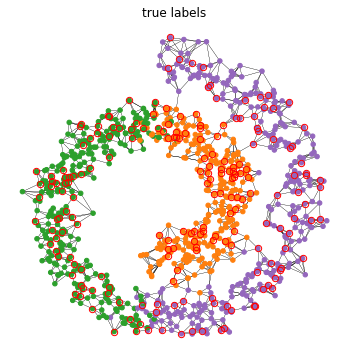

In [4]:
ei,ej,e = [],[],[]
with open(f"{savepath}/edge_list_orig.txt","r") as f:
    lines = f.readlines()
    num_nodes = int(lines[0].strip().split(' ')[0])
    for line in lines[1::]:
        line = line.strip().split(' ')
        ei.append(int(line[0]))
        ej.append(int(line[1]))
        e.append(int(line[2]))
G_orig = sp.csr_matrix((e,(ei,ej)),(num_nodes,num_nodes))
labels = np.load(f"{savepath}/labels.npy")
coords = np.load(f"{savepath}/coords.npy")
with open(f"{savepath}/train_nodes.txt","r") as f:
    lines = f.readlines()
    train_nodes = [int(i.strip()) for i in lines]
with open(f"{savepath}/val_nodes.txt","r") as f:
    lines = f.readlines()
    val_nodes = [int(i.strip()) for i in lines]
with open(f"{savepath}/test_nodes.txt","r") as f:
    lines = f.readlines()
    test_nodes = [int(i.strip()) for i in lines]

node_colors_class_truth = np.array([all_class_colors[i] for i in labels])
fig,ax = plt.subplots(figsize=(6,6))
plot_graph(G_orig,node_colors_class_truth,coords,fig=fig,ax=ax,s=20)
ax.scatter(coords[train_nodes,0],coords[train_nodes,1],edgecolors=(1,0,0),facecolors=(0,0,0,0),s=40,linewidths=1.0)
ax.scatter(coords[val_nodes,0],coords[val_nodes,1],edgecolors=(1,0,0),facecolors=(0,0,0,0),s=40,linewidths=1.0)
ax.set_title('true labels')

## Load precomputed graph and lens

Text(0.5, 1.0, 'predicted labels')

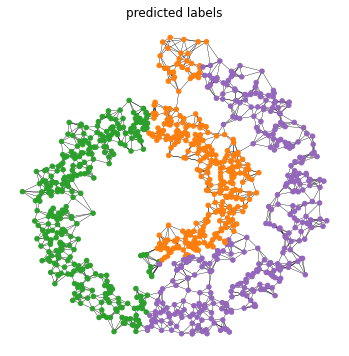

In [5]:
ei,ej,e = [],[],[]
with open(f"{savepath}/edge_list.txt","r") as f:
    lines = f.readlines()
    num_nodes = int(lines[0].strip().split(' ')[0])
    for line in lines[1::]:
        line = line.strip().split(' ')
        ei.append(int(line[0]))
        ej.append(int(line[1]))
        e.append(int(line[2]))
G = sp.csr_matrix((e,(ei,ej)),(num_nodes,num_nodes))
preds = np.load(f"{savepath}/prediction_lens.npy")
pred_labels = np.argmax(preds,1)

node_colors_class = np.array([all_class_colors[i] for i in pred_labels])
fig,ax = plt.subplots(figsize=(6,6))
plot_graph(G_orig,node_colors_class,coords,fig=fig,ax=ax,s=20)
ax.set_title('predicted labels')

## Compute Reeb graph and estimated errors

In [6]:
from GTDA.GTDA_utils import compute_reeb, NN_model
from GTDA.GTDA import GTDA

nn_model = NN_model()
nn_model.preds = preds
nn_model.labels = labels
nn_model.A = G
nn_model.train_mask = np.zeros(G.shape[0])
nn_model.train_mask[train_nodes] = 1
nn_model.val_mask = np.zeros(G.shape[0])
nn_model.val_mask[val_nodes] = 1
nn_model.test_mask = np.zeros(G.shape[0])
nn_model.test_mask[test_nodes] = 1
smallest_component = 20
overlap = 0.1
labels_to_eval = list(range(preds.shape[1]))
GTDA_record = compute_reeb(GTDA,nn_model,labels_to_eval,smallest_component,overlap,extra_lens=None,
    node_size_thd=5,reeb_component_thd=5,nprocs=10,device='cuda')

Preprocess lens..
Merge reeb nodes...
Build reeb graph...
Total time for building reeb graph is 3.500486135482788 seconds
Compute mixing rate for each sample


In [7]:
from GTDA.GTDA_utils import save_to_json
label_to_name = {
    0:"first class",
    1:"second class",
    2:"third class"
}
save_to_json(GTDA_record, nn_model, savepath, label_to_name)

## Visualize GTDA results

100%|██████████| 88/88 [00:00<00:00, 1198.26it/s]


(-12.975668479796122, 11.562953558039924)

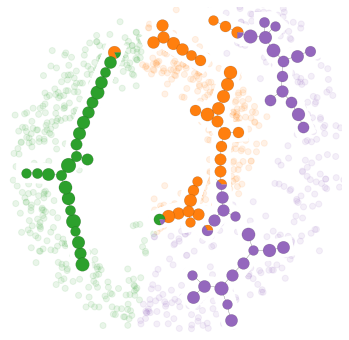

In [38]:
import networkx as nx
from GTDA.GTDA_utils import find_components, plot_reeb_component
import pandas as pd
from matplotlib.colors import to_rgba

gtda = GTDA_record['gtda']
g_reeb = GTDA_record['g_reeb']
reeb_components = find_components(g_reeb,size_thd=0)[1]
# mapping each Reeb graph component to the actual group of samples it represents
reeb_components_to_nodes = {}
for i,reeb_component in enumerate(reeb_components):
    nodes = []
    for reeb_node in reeb_component:
        # mapping a Reeb node to the actual group of samples it represents
        nodes += gtda.final_components_filtered[gtda.filtered_nodes[reeb_node]]
    if len(nodes) > 0:
        reeb_components_to_nodes[i] = np.unique(nodes)


xcoords = np.zeros(g_reeb.shape[0])
ycoords = np.zeros(g_reeb.shape[0])
g_reeb = g_reeb.tocsr()
for k,c in enumerate(reeb_components):
    g_sub = g_reeb[c,:][:,c]
    pos_init = {}
    for i,reeb_node in enumerate(c):
        nodes = gtda.final_components_filtered[gtda.filtered_nodes[reeb_node]]
        pos_init[i] = np.array([np.mean(coords[nodes,0]),np.mean(coords[nodes,1])])
    # compute a layout for each Reeb graph component
    pos_tmp = nx.kamada_kawai_layout(nx.from_scipy_sparse_matrix(g_sub),pos=pos_init,scale=1)
    for i,reeb_node in enumerate(c):
        xcoords[reeb_node] = pos_tmp[i][0]
        ycoords[reeb_node] = pos_tmp[i][1]

component_scales = [4,2,6,8,2,5]
for i,scale in enumerate(component_scales):
    c = reeb_components[i]
    for key in c:
        xcoords[key] *= scale
        ycoords[key] *= scale

for i,c in enumerate(reeb_components):
    nodes = reeb_components_to_nodes[i]
    center_coords = np.mean(coords[nodes],0)
    x_curr_center = np.mean(xcoords[c])
    y_curr_center = np.mean(ycoords[c])
    for j in c:
        xcoords[j] -= (x_curr_center-center_coords[0])
        ycoords[j] -= (y_curr_center-center_coords[1])

df = pd.DataFrame({'x':xcoords,'y':ycoords,'sizes':40*gtda.node_sizes[gtda.filtered_nodes]**0.5})

fig,ax = plt.subplots(figsize=(6,6))

sample_colors = [to_rgba(all_class_colors[pred_labels[i]],alpha=0.1) for i in range(coords.shape[0])]
ax.scatter(coords[:,0],coords[:,1],c=sample_colors,zorder=0)

g_reeb = g_reeb.tocoo()
for ei,ej in zip(g_reeb.row,g_reeb.col):
    ax.plot(
        [xcoords[ei],xcoords[ej]],
        [ycoords[ei],ycoords[ej]],
        c='white',linewidth=20,zorder=1)

fig,ax = plot_reeb_component(g_reeb,df,gtda.node_colors_class[gtda.filtered_nodes],
    labels_to_eval=[0,1,2],all_class_colors=all_class_colors,fig=fig,ax=ax,is_plotting_legend=False)

ax.set_xlim(np.min(xcoords)-1.5,np.max(xcoords)+2.5)
ax.set_ylim(np.min(ycoords)-1,np.max(ycoords)+1)

## Zoom in a component

100%|██████████| 172/172 [00:00<00:00, 924.40it/s]


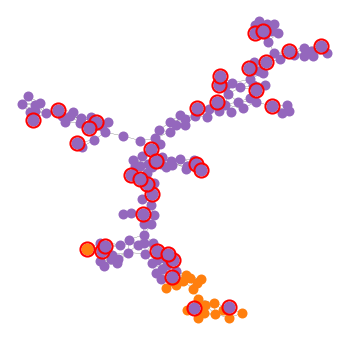

In [39]:
from GTDA.GTDA_utils import plot_subgraph

fig,ax = plt.subplots(figsize=(6,6))
component_index = 5
nodes = reeb_components_to_nodes[component_index]
# gtda.A_reeb is the projected Reeb graph
subg = gtda.A_reeb[nodes,:][:,nodes]
tmp_pos = nx.kamada_kawai_layout(nx.from_scipy_sparse_matrix(subg))
node_colors_pred = [all_class_colors[i] for i in pred_labels[reeb_components_to_nodes[component_index]]]
node_colors_truth = [all_class_colors[i] for i in labels[reeb_components_to_nodes[component_index]]]
tmp_known_nodes = nn_model.train_mask[reeb_components_to_nodes[component_index]] + nn_model.val_mask[reeb_components_to_nodes[component_index]]
fig,ax = plot_subgraph(node_colors_pred,tmp_pos,subg,nodesize=100,fig=fig,ax=ax)
for node in np.nonzero(tmp_known_nodes)[0]:
    ax.scatter(
        [tmp_pos[node][0]],[tmp_pos[node][1]],color=node_colors_truth[node],linewidths=2,s=100)
    ax.scatter(
        [tmp_pos[node][0]],[tmp_pos[node][1]],color=(0,0,0,0),linewidths=2,edgecolors='red',s=200)

## Visualize GTDA estimated errors

Text(0.5, 1.0, 'model uncertainty')

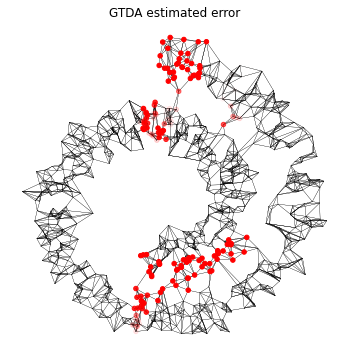

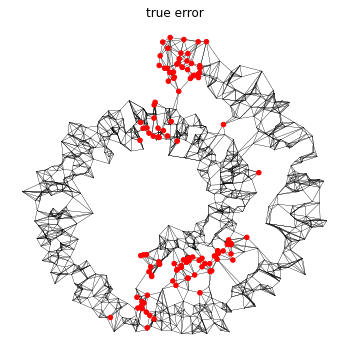

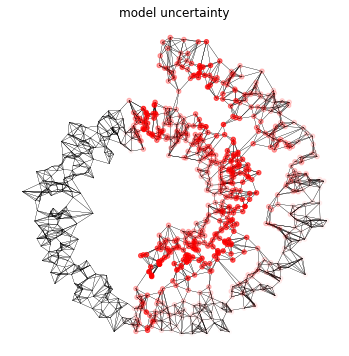

In [40]:
def plot_graph(A,node_colors,coords,fig=None,ax=None,s=20):
    if fig is None:
        fig,ax = plt.subplots()
    ax.scatter(coords[:,0],coords[:,1],c=node_colors,s=s)
    G = A.tocoo()
    for ei,ej in zip(G.row,G.col):
        ax.plot(
            [coords[ei][0],coords[ej][0]],
            [coords[ei][1],coords[ej][1]],
            c='black',zorder=-10,linewidth=0.2)
    ax.axis('off')
    return fig,ax

sample_colors_mixing = (gtda.sample_colors_mixing-np.min(gtda.sample_colors_mixing))/(np.max(gtda.sample_colors_mixing)-np.min(gtda.sample_colors_mixing))
sample_colors_mixing = [(1,0,0,sample_colors_mixing[i]) for i in range(len(labels))]
fig,ax = plt.subplots(figsize=(6,6))
plot_graph(G,sample_colors_mixing,coords,fig=fig,ax=ax,s=20)
ax.set_title('GTDA estimated error')

sample_colors_error = [(1,0,0,gtda.sample_colors_error[i]) for i in range(len(labels))]
fig,ax = plt.subplots(figsize=(6,6))
plot_graph(G,sample_colors_error,coords,fig=fig,ax=ax,s=20)
ax.set_title('true error')

sample_colors_uncertainty = (gtda.sample_colors_uncertainty-np.min(gtda.sample_colors_uncertainty))/(np.max(gtda.sample_colors_uncertainty)-np.min(gtda.sample_colors_uncertainty))
sample_colors_uncertainty = [(1,0,0,sample_colors_uncertainty[i]) for i in range(len(labels))]
fig,ax = plt.subplots(figsize=(6,6))
plot_graph(G,sample_colors_uncertainty,coords,fig=fig,ax=ax,s=20)
ax.set_title('model uncertainty')

## Compute Reeb graph using the original TDA

In [57]:
from GTDA.TDA import TDA

labels_to_eval = [0,1,2]
tda = TDA(nn_model,labels_to_eval)
M,Ar = tda.build_mixing_matrix(standardize=True)
tda.find_reeb_nodes(M,Ar,nbins=5,overlap=0.1)
g_reeb_tda = tda.build_reeb_graph(M)

Generate bins...
Find reeb nodes...
Build reeb graph...


## Visualize Reeb graph from the original TDA

100%|██████████| 19/19 [00:00<00:00, 1171.94it/s]


(-1.295901365782749, 1.295901421998013)

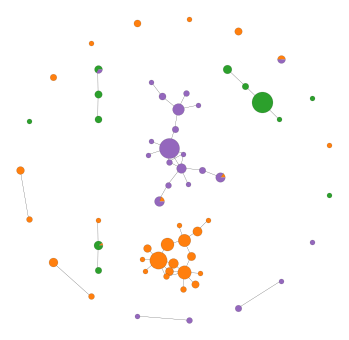

In [59]:
from GTDA.GTDA_utils import extend_coords
from collections import Counter
tda_reeb_components = find_components(g_reeb_tda,size_thd=0)[1]
tda_reeb_components_index = np.argsort([-1*len(c) for c in tda_reeb_components])
node_label_ratios = np.zeros((g_reeb_tda.shape[0],M.shape[1]))
node_sizes = np.zeros(g_reeb_tda.shape[0])
for i,c in tda.final_components_unique.items():
    node_sizes[i] = len(c)
    for i1,c1 in Counter(pred_labels[c]).items():
        node_label_ratios[i,i1] = c1/len(c)
node_sizes = 25*node_sizes**0.5
x = np.zeros(g_reeb_tda.shape[0])
y = np.zeros(g_reeb_tda.shape[0])
for j in range(len(tda_reeb_components_index)):
    component = tda_reeb_components[tda_reeb_components_index[j]]
    curr_pos = nx.kamada_kawai_layout(nx.from_scipy_sparse_matrix(g_reeb_tda[component,:][:,component]))
    for i,node in enumerate(component):
        x[node] = curr_pos[i][0]
        y[node] = curr_pos[i][1]
df_tda = pd.DataFrame({'x':x,'y':y,'sizes':node_sizes})
fig,ax = plt.subplots(figsize=(6,6))
component = tda_reeb_components[tda_reeb_components_index[0]]
for i in component:
    x[i] *= 0.5
    y[i] *= 0.5
for i in component:
    y[i] += 0.2
df_tda = pd.DataFrame({'x':x[component],'y':y[component],'sizes':node_sizes[component]})
plot_reeb_component(
    g_reeb_tda[component,:][:,component],df_tda,node_label_ratios[component],all_class_colors=all_class_colors,
    labels_to_eval=tda.labels_to_eval,is_plotting_legend=False,fig=fig,ax=ax)
component = tda_reeb_components[tda_reeb_components_index[1]]
for i in component:
    x[i] *= 0.3
    y[i] *= 0.3
for i in component:
    y[i] -= 0.7
df_tda = pd.DataFrame({'x':x[component],'y':y[component],'sizes':node_sizes[component]})
plot_reeb_component(
    g_reeb_tda[component,:][:,component],df_tda,node_label_ratios[component],all_class_colors=all_class_colors,
    labels_to_eval=tda.labels_to_eval,is_plotting_legend=False,fig=fig,ax=ax)
component = tda_reeb_components[tda_reeb_components_index[2]]
for i in component:
    x[i] *= 0.2
    y[i] *= 0.2
for i in component:
    x[i] += 0.6
    y[i] += 0.6
df_tda = pd.DataFrame({'x':x[component],'y':y[component],'sizes':node_sizes[component]})
plot_reeb_component(
    g_reeb_tda[component,:][:,component],df_tda,node_label_ratios[component],all_class_colors=all_class_colors,
    labels_to_eval=tda.labels_to_eval,is_plotting_legend=False,fig=fig,ax=ax)

component = tda_reeb_components[tda_reeb_components_index[3]]
for i in component:
    x[i] *= 0.2
    y[i] *= 0.2
for i in component:
    x[i] -= 0.6
    y[i] -= 0.6
df_tda = pd.DataFrame({'x':x[component],'y':y[component],'sizes':node_sizes[component]})
plot_reeb_component(
    g_reeb_tda[component,:][:,component],df_tda,node_label_ratios[component],all_class_colors=all_class_colors,
    labels_to_eval=tda.labels_to_eval,is_plotting_legend=False,fig=fig,ax=ax)

component = tda_reeb_components[tda_reeb_components_index[4]]
for i in component:
    x[i] *= 0.2
    y[i] *= 0.2
for i in component:
    x[i] -= 0.6
    y[i] += 0.6
df_tda = pd.DataFrame({'x':x[component],'y':y[component],'sizes':node_sizes[component]})
plot_reeb_component(
    g_reeb_tda[component,:][:,component],df_tda,node_label_ratios[component],all_class_colors=all_class_colors,
    labels_to_eval=tda.labels_to_eval,is_plotting_legend=False,fig=fig,ax=ax)

nodes = []
for k in range(5,len(tda_reeb_components_index)):
    component = tda_reeb_components[tda_reeb_components_index[k]]
    nodes += component
curr_pos = nx.shell_layout(nx.from_scipy_sparse_matrix(g_reeb_tda[nodes,:][:,nodes]),scale=6)
center = np.mean(np.vstack(list(curr_pos.values())),0)
for i,node in enumerate(nodes):
    new_coord = extend_coords(center, curr_pos[i], 0.2)
    x[node] = new_coord[0]
    y[node] = new_coord[1]
df_tda = pd.DataFrame({'x':x[nodes],'y':y[nodes],'sizes':node_sizes[nodes]})
plot_reeb_component(
    g_reeb_tda[nodes,:][:,nodes],df_tda,node_label_ratios[nodes],all_class_colors=all_class_colors,
    labels_to_eval=tda.labels_to_eval,is_plotting_legend=False,fig=fig,ax=ax)

ax.set_xlim(np.min(x)-0.1,np.max(x)+0.1)
ax.set_ylim(np.min(y)-0.1,np.max(y)+0.1)